First, set $Y_t = \sigma W_t - \frac{1}{2} \sigma^2t$.
We have that $dY_t = \sigma dW_t - \frac{1}{2} \sigma^2 dt$. Using Itô's formula with $f(x) = s_0e^x$, we obtain: 
\begin{equation}
\begin{split}
dS_t &= df(X_t) \\
&= \left(\frac{1}{2}\sigma^2 S_t - \frac{1}{2}\sigma^2 S_t\right)dt + \sigma S_t dW_t \\
&= \sigma S_t dW_t
\end{split}
\end{equation}
Which is exactly the Black-Scholes equation with null risk-free rate.


### Generate dataset

In [81]:
import torch
import time

N = 30
T = 30 / 365
s0 = 1
sigma = 0.5

Train = torch.stack([torch.cat((torch.tensor([s0]),
                                torch.exp(torch.cumsum(- (sigma**2 * T) / (2 * N)
                                + sigma * torch.sqrt(torch.tensor(T / N)) 
                                * torch.randn(N), dim=0)))) for _ in range(10**5)])

Test = torch.stack([torch.cat((torch.tensor([s0]),
                               torch.exp(torch.cumsum(- (sigma**2 * T) / (2 * N)
                                + sigma * torch.sqrt(torch.tensor(T / N)) 
                                * torch.randn(N), dim=0)))) for _ in range(10**4)])

### Model implementation

In [82]:

nh1 = 64
nh2 = 64
nh3 = 32

networks = [torch.nn.Sequential(
    torch.nn.Linear(1, nh1),
    torch.nn.ReLU(),
    torch.nn.Linear(nh1, nh2),
    torch.nn.ReLU(),
    torch.nn.Linear(nh2, nh3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(nh3, 1)
) for _ in range(N)]


### Model training

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:55<00:00,  2.35s/it, loss=7.98e-5]


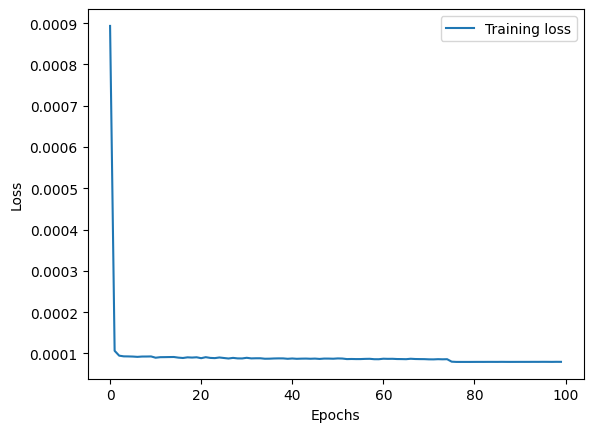

In [83]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
K = 1
g = lambda x: torch.relu(x-K)

def C(x: torch.Tensor, t: float):
    d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(x / K)) + (sigma ** 2 / 2) * (T - t))
    d_minus = d_plus - sigma * torch.sqrt(torch.tensor(T - t))
    return torch.special.ndtr(d_plus) * x - torch.special.ndtr(d_minus) * K

p = C(1,0)
n_epochs = 100
lr = 1e-2
batch_size = 1000
milestones = [75]

optimizer = torch.optim.Adam([param for network in networks for param in network.parameters()], lr=lr)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

train_loader = DataLoader(TensorDataset(Train), batch_size=batch_size, shuffle=True)

M1_TST = time.time()
losses = []
training_loop = tqdm(range(n_epochs)) 
for epoch in training_loop:
    epoch_loss = 0
    for batch in train_loader:
        batch = batch[0]
        s_T = batch[:, -1]
        H = torch.zeros(batch.size(0),N) 
        optimizer.zero_grad()
        H = torch.stack([networks[i](torch.log(batch[:, i]).unsqueeze(1)).squeeze() for i in range(N)], dim=1)     
        S = batch[:, 1:] - batch[:, :-1]  
        batch_loss = ((g(s_T) - p - torch.sum(H * S, dim=1)) ** 2).mean()
        
        batch_loss.backward()
        optimizer.step()
        

        epoch_loss += batch_loss.item()

    epoch_loss /= len(train_loader)
    training_loop.set_postfix(loss=epoch_loss)
    
    scheduler.step()

    losses.append(epoch_loss)
M1_TET = time.time()

plt.plot(losses, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Model evaluation

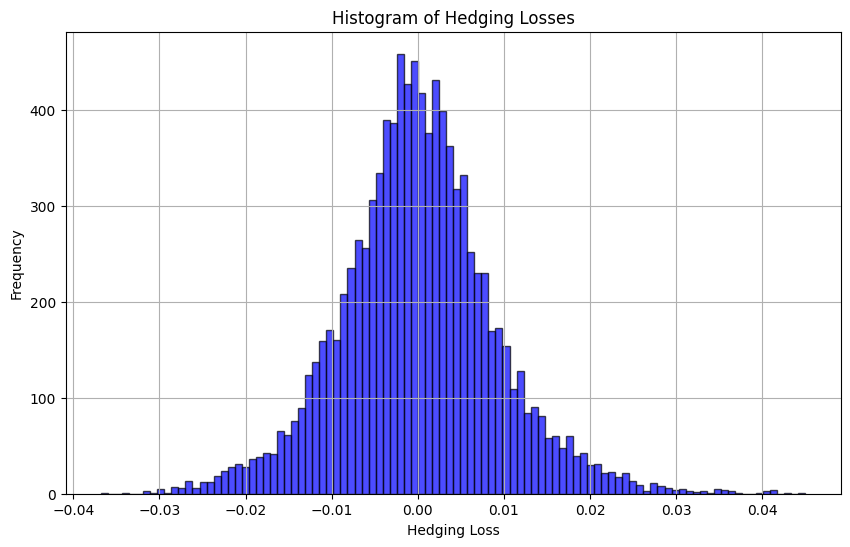

Mean of hedging losses: -0.0000
Standard deviation of hedging losses: 0.0091


In [84]:
S_T = Test[:,-1]
H_test = torch.zeros(Test.size(0),N)
for i in range(N):
    input_data = torch.log(Test[:, i]).unsqueeze(1)  
    H_test[:, i] = networks[i](input_data).squeeze()    
S_test = Test[:, 1:] - Test[:, :-1] 
loss = (g(S_T) - p - torch.sum(H_test * S_test, dim=1)).detach()


plt.figure(figsize=(10, 6))
plt.hist(loss.numpy(), bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Hedging Losses')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

mean_loss = torch.mean(loss).item()
std_loss = torch.std(loss).item()
print(f"Mean of hedging losses: {mean_loss:.4f}")
print(f"Standard deviation of hedging losses: {std_loss:.4f}")

### Analytical solution


\begin{align*}
H^{\text{BS}}_t(s) & = \frac{\partial C(s, t)}{\partial s} \\
& = \frac{\partial }{\partial s} \left( \Phi(d_+) s - \Phi(d_+ - \sigma \sqrt{T-t})Ke^{-r(T-t)} \right) \\
&= (\frac{\partial}{\partial s} d_+) \Phi '(d_+)s + \Phi(d_+) - (\frac{\partial}{\partial s} d_+) \Phi'(d_+ - \sigma \sqrt{T-t})Ke^{-r(T-t)}
\end{align*}

Now, as 
\begin{align*}
\frac{\partial}{\partial s}d_+ &= \frac{\partial}{\partial s} \frac{1}{\sigma \sqrt{T-t}} \left( \log(s/K) + (r + \sigma^2/2)(T-t)\right) \\
&= \frac{1}{s\sigma\sqrt{T-t}}
\end{align*}
We obtain
\begin{align*}
\frac{\partial C(s,t)}{\partial s} &= \frac{1}{s\sigma \sqrt{T-t}} \Phi'(d_+)s + \Phi(d_+) - \frac{1}{s\sigma\sqrt{T-t}} \Phi'(d_-)Ke^{-r(T-t)}\\
&= \frac{1}{s\sigma\sqrt{T-t}} \left(\Phi'(d_+)s - \Phi'(d_-)Ke^{-r(T-t)} \right) + \Phi(d_+)
\end{align*}

Lastly, notice that
\begin{align*}
Ke^{-r(T-t)} \Phi'(d_-) &= Ke^{-r(T-t)} \frac{1}{\sqrt{2\pi}} e^{-(d_+ - \sigma \sqrt{T-t})^2 /2} \\
&= Ke^{-r(T-t)} e^{d_+ \sigma \sqrt{T-t}} e^{-\sigma^2 \frac{T-t}{2}} \Phi'(d_+) \\
&=Ke^{-(r + \sigma^2/2)(T-t)} \frac{s}{K} e^{(r+\sigma^2/2)(T-t)} \Phi'(d_+) \\
&= s\Phi'(d_+)
\end{align*}

Thus 

$$H^{\text{BS}}_t(s) = \Phi(d_+)$$

### Analytical solution evaluation

/var/folders/1p/fz7nlz5n43x05ck6k83j31340000gn/T/ipykernel_37722/3317175067.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(s / K)) + (sigma ** 2 / 2) * (T - t))


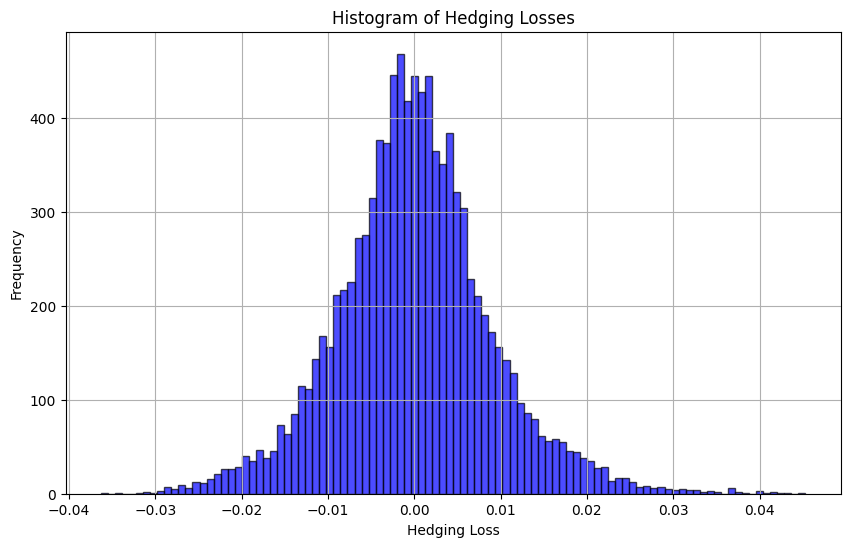

Mean of hedging losses: -0.0000
Standard deviation of hedging losses: 0.0090


In [85]:
from torch.distributions import Normal

def dsC(s: torch.Tensor, t: float):
    d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(s / K)) + (sigma ** 2 / 2) * (T - t))
    return torch.special.ndtr(d_plus)



times = T*torch.arange(0,N)/N
s = Test[:, :-1]
H_analytical = torch.stack([dsC(s[i], times) for i in range(s.size(0))])
analytical_loss = (g(S_T) - p - torch.sum(H_analytical * S_test, dim=1)).detach()

plt.figure(figsize=(10, 6))
plt.hist(analytical_loss, bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Hedging Losses')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

amean_loss = torch.mean(analytical_loss).item()
astd_loss = torch.std(analytical_loss).item()
print(f"Mean of hedging losses: {amean_loss:.4f}")
print(f"Standard deviation of hedging losses: {astd_loss:.4f}")
    


### Learned strategy comparison

/var/folders/1p/fz7nlz5n43x05ck6k83j31340000gn/T/ipykernel_37722/405661852.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(s_plot.numpy(),networks[j](torch.log(torch.tensor(s_plot)).unsqueeze(1)).squeeze().detach().numpy(), label=f'$H_{{t_{j}}}$ (NN)', linestyle='--')
/var/folders/1p/fz7nlz5n43x05ck6k83j31340000gn/T/ipykernel_37722/3317175067.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(s / K)) + (sigma ** 2 / 2) * (T - t))


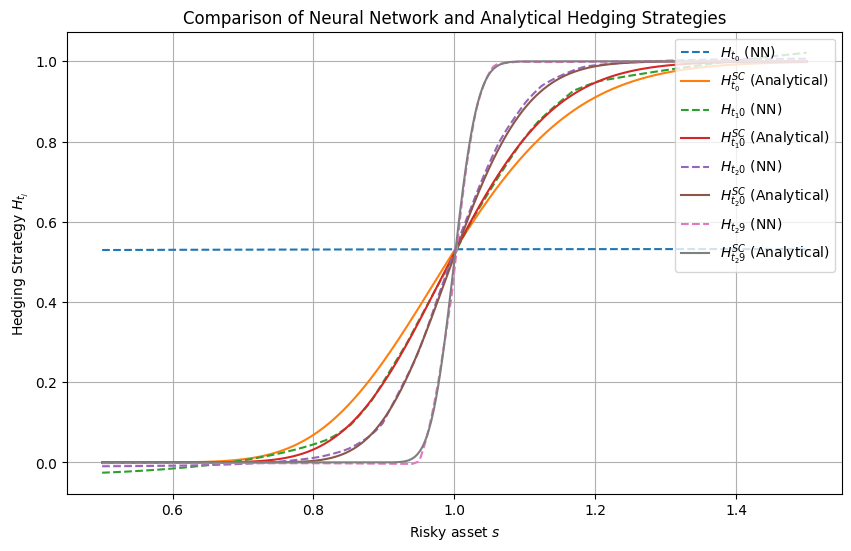

In [86]:
s_plot = torch.linspace(0.5, 1.5, 1000)  
s_plot_net = s_plot.view(-1, 1).repeat(1, 30) 

index = torch.tensor([0, 10, 20, 29])  

plt.figure(figsize=(10, 6))

for j in index:
    
    plt.plot(s_plot.numpy(),networks[j](torch.log(torch.tensor(s_plot)).unsqueeze(1)).squeeze().detach().numpy(), label=f'$H_{{t_{j}}}$ (NN)', linestyle='--')

    plt.plot(s_plot.numpy(), dsC(s_plot, T * j / N).detach().numpy(), label=f'$H^{{SC}}_{{t_{j}}}$ (Analytical)')

plt.xlabel('Risky asset $s$')
plt.ylabel('Hedging Strategy $H_{t_j}$')
plt.title('Comparison of Neural Network and Analytical Hedging Strategies')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

### Model implementation

In [87]:
complete_network = torch.nn.Sequential(torch.nn.Linear(2, nh1),
    torch.nn.ReLU(),
    torch.nn.Linear(nh1, nh2),
    torch.nn.ReLU(),
    torch.nn.Linear(nh2, nh3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(nh3, 1)
)


### Model training

100%|██████████| 100/100 [02:18<00:00,  1.38s/it, loss=7.93e-5]


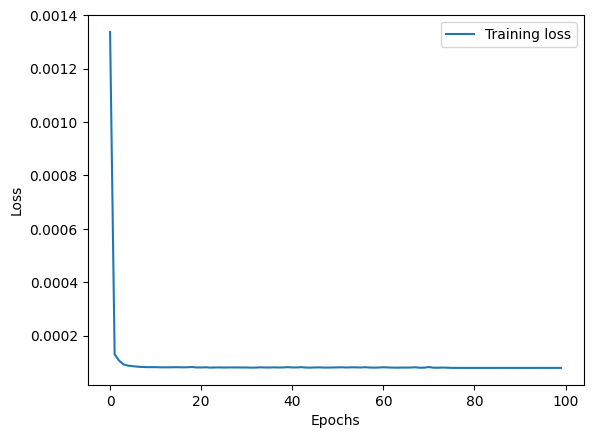

In [88]:


M2_TST = time.time()
optimizer = torch.optim.Adam(complete_network.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

train_loader = DataLoader(TensorDataset(Train), batch_size=batch_size, shuffle=True)

losses = []
training_loop = tqdm(range(n_epochs)) 
for epoch in training_loop:
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        batch = batch[0]  
        s_T = batch[:, -1]

        log_S_t = torch.log(batch[:, :-1])
        times = torch.sqrt(T-torch.linspace(0, T, steps=N+1)[:-1]).repeat(batch.shape[0],1)
        inputs = torch.stack((times,log_S_t), dim=2)
    
        
        H = complete_network(inputs).squeeze()

        S = batch[:, 1:] - batch[:, :-1]  

        batch_loss = ((g(s_T) - p - torch.sum(H * S, dim=1)) ** 2).mean() 

        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

    epoch_loss /= len(train_loader)
    training_loop.set_postfix(loss=epoch_loss)
    
    scheduler.step()

    losses.append(epoch_loss)
M2_TET = time.time()
plt.plot(losses, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model evaluation

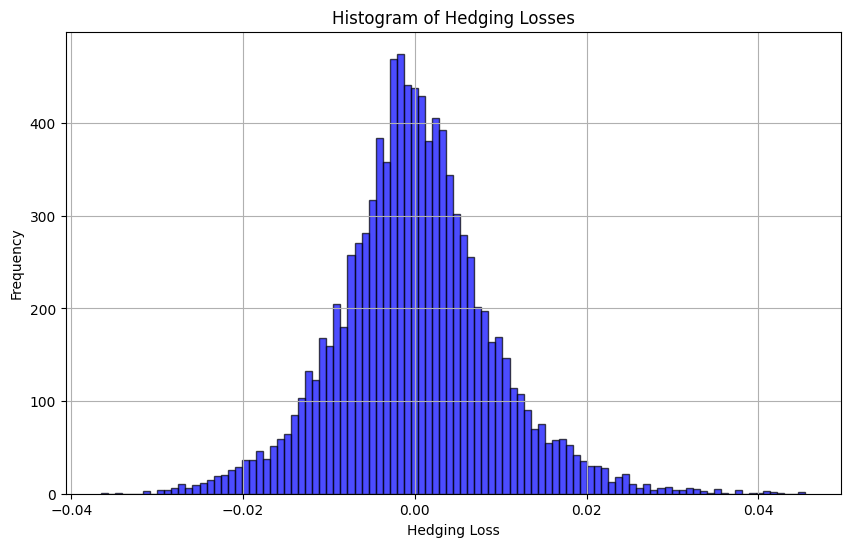

Mean of hedging losses: 0.0000
Standard deviation of hedging losses: 0.0091


In [89]:
import numpy as np
losstest = []
times = torch.linspace(0, T, steps=N+1).unsqueeze(1)
for i in range(10**4):
        log_S_t = torch.log(Test[i][:-1]).unsqueeze(1)

        inputs = torch.cat((torch.sqrt(T-times[:-1]),log_S_t), dim=1)

        H = complete_network(inputs) 
        path_loss = g(Test[i][-1]) - p - torch.sum(H.squeeze() * (Test[i][1:] - Test[i][:-1]))
        losstest.append(path_loss.detach())




plt.figure(figsize=(10, 6))
plt.hist(losstest, bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Hedging Losses')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

mean_loss = np.mean(losstest)
std_loss = np.std(losstest)
print(f"Mean of hedging losses: {mean_loss:.4f}")
print(f"Standard deviation of hedging losses: {std_loss:.4f}")

### Model comparison

Our models have similar performance, however we noticed that the second deep hedging model required significantly less parameters and took less time to train.

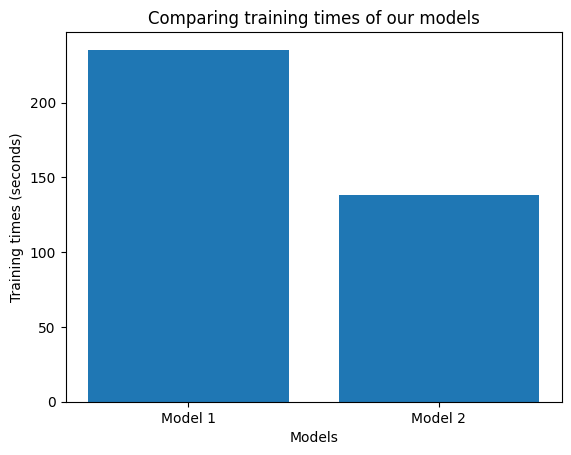

Training time for the first deep heding model:235.28474068641663 seconds.
Training time for the second deep heding model:138.37286496162415 seconds.


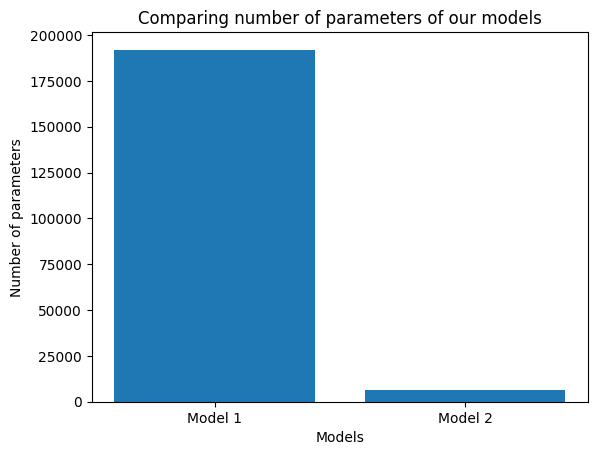

Number of parameters in the first deep hedging model:192030.
Number of parameters in the second deep heding model:6465.


In [ ]:
models = ['Model 1', 'Model 2']
times = [M1_TET - M1_TST, M2_TET - M2_TST]
plt.figure()
plt.bar(models, times)
plt.xlabel('Models')
plt.ylabel('Training times (seconds)')
plt.title('Comparing training times of our models')
plt.show()
print(f'Training time for the first deep heding model:{M1_TET - M1_TST} seconds.')
print(f'Training time for the second deep heding model:{M2_TET - M2_TST} seconds.')

parameters = [sum([param.numel()for network in networks for param in network.parameters()]), sum([param.numel() for param in complete_network.parameters()])]
plt.figure()
plt.bar(models, parameters)
plt.xlabel('Models')
plt.ylabel('Number of parameters')
plt.title('Comparing number of parameters of our models')
plt.show()



print(f'Number of parameters in the first deep hedging model:{sum([param.numel()for network in networks for param in network.parameters()])}.')
print(f'Number of parameters in the second deep heding model:{sum([param.numel() for param in complete_network.parameters()])}.')
